In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
import functions as f
from glob import glob
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from datetime import datetime
import datetime as dt
import preprocessUtils as putils
import masks
import verifications
from ridgeplot import ridgeplot
import joypy
import seaborn as sns
from matplotlib import cm
import climpred
from xclim import sdba
from climpred.options import OPTIONS
import json
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.lines import Line2D  # For custom legend entries
from multiprocessing import Pool, Manager
import random
from numpy.random import randn, seed
from scipy import stats

2024-08-16 09:45:35.177054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 09:46:09.946297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir = '/glade/work/klesinger/FD_RZSM_deep_learning'

global dim_order, region_name, obs_anom_percentile_thresholds, obs_anom_percentile, week_lead, percentile, UNET_experiment_name,ensemble_threshold
dim_order = ['S','M','L','Y','X']

region_list = ['CONUS','australia','china']


In [ ]:
''''Save each mask within a dictionary for later use'''
masks_dict = {}
for region_name in region_list:
    masks_dict[region_name] = masks.load_mask(region_name)
    #Mask with np.nan for non-CONUS land values
    masks_dict[region_name] = masks_dict[region_name][putils.xarray_varname(masks_dict[region_name])][0,:,:].values

In [ ]:
test_start = '2018-01-01'
test_end = '2019-12-31'
val_start = '2015-01-01'
val_end = '2017-12-31'
train_start  = '2000-01-01'
train_end  = '2015-12-31'

global test_year
test_year = 2019

leads_ = [6,13,20,27,34]

In [ ]:
'''Open each file for each region and model and save a a dictionary for later processing'''
region_data_dict = {}

global obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only

obs_anomaly_SubX_format = {}
baseline_anomaly = {}
baseline_ecmwf = {}

for idx,region_name in enumerate(region_list):
    # break
    obs_anomaly_SubX_format[region_name], baseline_anomaly[region_name], baseline_ecmwf[region_name], var_OUT, template_testing_only = verifications.open_obs_and_baseline_files_multiple_leads(region_name, leads_, test_start, test_end, masks_dict[region_name])

In [ ]:
'''We now have all of the baseline files loaded, now we need to open up the observations in the original format'''
obs_anomaly_raw_format = {}

for idx,region_name in enumerate(region_list):
    
    #Load observation anomaly as raw file
    if region_name == 'CONUS':
        source = 'Data/GLEAM'
        gefs_source = 'Data'
    else:
        source = f'Data_{region_name}/GLEAM'
        gefs_source = f'Data_{region_name}'

    global obs_original,obs_raw
    obs_original = xr.open_dataset(f'{source}/RZSM_anomaly.nc').rename({'SMsurf':'RZSM'}).load()
    obs_anomaly_raw_format[region_name] = obs_original


init_dates = putils.get_init_date_list('Data/GEFSv12_reforecast/soilw_bgrnd')
dt_dates = [pd.to_datetime(i) for i in init_dates]

only_testing_dates = [i for i in dt_dates if i >= pd.to_datetime('2018-01-01')]

In [ ]:
#Open the gleam percentile/anom files

obs_anom_percentile = {}

for idx,region_name in enumerate(region_list):
    
    #Load observation anomaly as raw file
    if region_name == 'CONUS':
        source = 'Data/GLEAM'
        gefs_source = 'Data'
    else:
        source = f'Data_{region_name}/GLEAM'
        gefs_source = f'Data_{region_name}'
        
    obs_anom_op = xr.open_mfdataset(f'{source}/RZSM_anom_and_percentile_reformat/*').sel(S=slice(test_start,test_end)).load()
    obs_anom_op['S'] = only_testing_dates
    
    obs_anom_percentile[region_name] = obs_anom_op

In [ ]:

obs_anom_percentile_thresholds = {}

for idx,region_name in enumerate(region_list):
    
    #Load observation anomaly as raw file
    if region_name == 'CONUS':
        source = 'Data/GLEAM'
        gefs_source = 'Data'
    else:
        source = f'Data_{region_name}/GLEAM'
        gefs_source = f'Data_{region_name}'

    anom_obs_perc = xr.open_dataset(f'Data/GLEAM/anomaly_percentile_RZSM_full_distribution_with_different_thresholds.nc4').load()
    anom_obs_perc = anom_obs_perc.rename({'latitude':'Y','longitude':'X'})

    obs_anom_percentile_thresholds[region_name] = anom_obs_perc

In [ ]:
'''Now we want to open the ensemble forecasts and determine the percentage of correct forecasts below a specific percentile'''

'''We will employ random sampling and create a confidence interval'''

###Testing
# week_lead = 1
# percentile = 20
# UNET_experiment_name = 'EX29_regular_RZSM'
# ensemble_threshold = 0.5

def compute_correct_forecasts_with_sampling_no_multiprocessing(obs_anom_percentile_thresholds, obs_anom_percentile, week_lead, percentile, UNET_experiment_name,ensemble_threshold):
    gefs_TPR = []
    gefs_FPR = []
    gefs_gilbert = []

    ecm_TPR = []
    ecm_FPR = []
    ecm_gilbert = []

    unet_TPR = []
    unet_FPR = []
    unet_gilbert = []
    
    day_num =(week_lead*7) -1
    
    '''Get the random choices'''
    proceed, reg, grid_x, grid_y = verifications.random_region_and_grid_selection(obs_anom_percentile_thresholds)
    
    if proceed == 'Yes':
        '''Now open the files for anomalies (raw files and UNET prediction file)'''
        obs, gefs, ecmwf, obs_anom_percentile_thresholds_out, obs_anom_percentile_out, unet_file = verifications.open_all_files_for_sampling(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, reg, grid_x, grid_y, day_num,obs_anom_percentile_thresholds, percentile,UNET_experiment_name,week_lead, test_year,obs_anom_percentile)

        '''Now get only the observations that fall below the percentile threshold'''
        obs_below_final = xr.where(obs<obs_anom_percentile_out, obs,np.nan).mean(dim='M')

        '''Now find the raw and UNET predictions and see if they are also below the 20th percentile'''
        gefs_below_final = xr.where(gefs<obs_anom_percentile_out, 1,np.nan).sum(dim='M')
        ecmwf_below_final = xr.where(ecmwf<obs_anom_percentile_out, 1,np.nan).sum(dim='M')
        unet_below_final = xr.where(unet_file<obs_anom_percentile_out, 1,np.nan).sum(dim='M')

        '''Now only keep if they are above a specific theshold'''
        for m,n in zip([gefs_below_final, ecmwf_below_final, unet_below_final], ['gefs','ecmwf','unet']):
            # break
            TP, FP, TN, FN, total_inits = verifications.accuracy(obs_below_final, m, ensemble_threshold)

            try:
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)

                #gilbert skill score
                numerator = TP - (TP + FN) * (TP + FP) / (TP + FN + FP + TN)
                denominator = TP + FN + FP - (TP + FN) * (TP + FP) / (TP + FN + FP + TN)

                if denominator == 0:
                    gilbert =  0
                else:
                     gilbert = numerator / denominator
                                
                if n == 'gefs':
                    gefs_TPR.append(TPR)
                    gefs_FPR.append(FPR)
                    gefs_gilbert.append(gilbert)
                elif n == 'ecmwf':
                    ecm_TPR.append(TPR)
                    ecm_FPR.append(FPR)
                    ecm_gilbert.append(gilbert)
                elif n == 'unet':
                    unet_TPR.append(TPR)
                    unet_FPR.append(FPR)   
                    unet_gilbert.append(gilbert)
            except ZeroDivisionError:
                pass

    
    return(gefs_TPR, gefs_FPR, ecm_TPR, ecm_FPR, unet_TPR, unet_FPR,gefs_gilbert, ecm_gilbert, unet_gilbert)

In [ ]:

def run_simulation_by_week_no_multiprocessing(week_lead, UNET_experiment_name,ensemble_threshold, percentile):

    out_dir = f'Outputs/TPR_FPR_GSS'
    os.system(f'mkdir -p {out_dir}')

    save_file = f'{out_dir}/Wk{week_lead}_simulation_metrics.csv'
    
    try:
        pd.read_csv(save_file)
    except FileNotFoundError:
        
    
        gefs_TPR, gefs_FPR, gefs_GSS, ecm_TPR, ecm_FPR, ecm_GSS, unet_TPR, unet_FPR, unet_GSS = [],[],[],[],[],[],[],[],[]
        
        completed_total = 0
        for _ in range(1000000):
            while completed_total < 50000 *9:
                if completed_total %9000 == 0:
                    print(f'Completed {completed_total/9} simulations')
                gefs_T, gefs_F, ecm_T, ecm_F, unet_T, unet_F, gefs_G, ecm_G, unet_G = compute_correct_forecasts_with_sampling_no_multiprocessing(obs_anom_percentile_thresholds, obs_anom_percentile, week_lead, percentile, UNET_experiment_name,ensemble_threshold)
        
                for sample_output, values in zip([gefs_TPR, gefs_FPR, ecm_TPR, ecm_FPR, unet_TPR, unet_FPR, gefs_GSS, ecm_GSS, unet_GSS],[gefs_T, gefs_F, ecm_T , ecm_F, unet_T, unet_F, gefs_G, ecm_G, unet_G]):
                    try:
                        sample_output.append(values[0])
                        completed_total +=1
                        # print(f'Completed {completed_total/9} number of successful samples')
                    except IndexError:
                        pass
        
    
        # Create DataFrame
        df = pd.DataFrame({
            'GEFSv12_TPR': gefs_TPR,
            'GEFSv12_FPR': gefs_FPR,
            'GEFSv12_GSS': gefs_GSS,
            'ECMWF_TPR': ecm_TPR,
            'ECMWF_FPR': ecm_FPR,
            'ECMWF_GSS': ecm_GSS,
            'UNET_TPR': unet_TPR,
            'UNET_FPR': unet_FPR,
            'UNET_GSS': unet_GSS,
        })
    
        
        df.to_csv(save_file)

# Run function without multiprocessing

In [ ]:
# for week_lead in [3,4,5]:
#     run_simulation_by_week(week_lead, UNET_experiment_name='EX29_regular_RZSM',ensemble_threshold=0.5, percentile=20)

# With multiprocessing (see below)

In [ ]:
'''This helps to create randomness within the multiprocessing function'''
def init_pool_processes():
    seed()

In [ ]:
'''Now we want to open the ensemble forecasts and determine the percentage of correct forecasts below a specific percentile'''

'''We will employ random sampling and create a confidence interval'''

###Testing
# week_lead = 1
# percentile = 20
# UNET_experiment_name = 'EX29_regular_RZSM'
# ensemble_threshold = 0.5



def compute_correct_forecasts_with_sampling_with_multiprocessing_week_3(placeholder):
    gefs_TPR = []
    gefs_FPR = []
    gefs_gilbert = []

    ecm_TPR = []
    ecm_FPR = []
    ecm_gilbert = []

    unet_TPR = []
    unet_FPR = []
    unet_gilbert = []

    week_lead=3
    
    day_num =(week_lead*7) -1

    random.seed(os.getpid())
    
    '''Get the random choices'''
    proceed, reg, grid_x, grid_y = verifications.random_region_and_grid_selection(obs_anom_percentile_thresholds)

    # print(f'Grid X is {grid_x}')
    
    if proceed == 'Yes':
        '''Now open the files for anomalies (raw files and UNET prediction file)'''
        obs, gefs, ecmwf, obs_anom_percentile_thresholds_out, obs_anom_percentile_out, unet_file = verifications.open_all_files_for_sampling(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, reg, grid_x, grid_y, day_num,obs_anom_percentile_thresholds, percentile,UNET_experiment_name,week_lead, test_year,obs_anom_percentile)

        '''Now get only the observations that fall below the percentile threshold'''
        obs_below_final = xr.where(obs<obs_anom_percentile_out, obs,np.nan).mean(dim='M')

        '''Now find the raw and UNET predictions and see if they are also below the 20th percentile'''
        gefs_below_final = xr.where(gefs<obs_anom_percentile_out, 1,np.nan).sum(dim='M')
        ecmwf_below_final = xr.where(ecmwf<obs_anom_percentile_out, 1,np.nan).sum(dim='M')
        unet_below_final = xr.where(unet_file<obs_anom_percentile_out, 1,np.nan).sum(dim='M')

        '''Now only keep if they are above a specific theshold'''
        for m,n in zip([gefs_below_final, ecmwf_below_final, unet_below_final], ['gefs','ecmwf','unet']):
            # break
            TP, FP, TN, FN, total_inits = verifications.accuracy(obs_below_final, m, ensemble_threshold)

            try:
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)

                #gilbert skill score
                numerator = TP - (TP + FN) * (TP + FP) / (TP + FN + FP + TN)
                denominator = TP + FN + FP - (TP + FN) * (TP + FP) / (TP + FN + FP + TN)

                if denominator == 0:
                    gilbert =  0
                else:
                     gilbert = numerator / denominator
                                
                if n == 'gefs':
                    gefs_TPR.append(TPR)
                    gefs_FPR.append(FPR)
                    gefs_gilbert.append(gilbert)
                elif n == 'ecmwf':
                    ecm_TPR.append(TPR)
                    ecm_FPR.append(FPR)
                    ecm_gilbert.append(gilbert)
                elif n == 'unet':
                    unet_TPR.append(TPR)
                    unet_FPR.append(FPR)   
                    unet_gilbert.append(gilbert)
            except ZeroDivisionError:
                pass

    try:
        return([gefs_TPR[0], gefs_FPR[0], ecm_TPR[0], ecm_FPR[0], unet_TPR[0], unet_FPR[0],gefs_gilbert[0], ecm_gilbert[0], unet_gilbert[0]])
    except IndexError:
        return([])

In [ ]:
def compute_correct_forecasts_with_sampling_with_multiprocessing_week_4(placeholder):
    gefs_TPR = []
    gefs_FPR = []
    gefs_gilbert = []

    ecm_TPR = []
    ecm_FPR = []
    ecm_gilbert = []

    unet_TPR = []
    unet_FPR = []
    unet_gilbert = []

    week_lead=4
    
    day_num =(week_lead*7) -1

    random.seed(os.getpid())
    
    '''Get the random choices'''
    proceed, reg, grid_x, grid_y = verifications.random_region_and_grid_selection(obs_anom_percentile_thresholds)

    # print(f'Grid X is {grid_x}')
    
    if proceed == 'Yes':
        '''Now open the files for anomalies (raw files and UNET prediction file)'''
        obs, gefs, ecmwf, obs_anom_percentile_thresholds_out, obs_anom_percentile_out, unet_file = verifications.open_all_files_for_sampling(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, reg, grid_x, grid_y, day_num,obs_anom_percentile_thresholds, percentile,UNET_experiment_name,week_lead, test_year,obs_anom_percentile)

        '''Now get only the observations that fall below the percentile threshold'''
        obs_below_final = xr.where(obs<obs_anom_percentile_out, obs,np.nan).mean(dim='M')

        '''Now find the raw and UNET predictions and see if they are also below the 20th percentile'''
        gefs_below_final = xr.where(gefs<obs_anom_percentile_out, 1,np.nan).sum(dim='M')
        ecmwf_below_final = xr.where(ecmwf<obs_anom_percentile_out, 1,np.nan).sum(dim='M')
        unet_below_final = xr.where(unet_file<obs_anom_percentile_out, 1,np.nan).sum(dim='M')

        '''Now only keep if they are above a specific theshold'''
        for m,n in zip([gefs_below_final, ecmwf_below_final, unet_below_final], ['gefs','ecmwf','unet']):
            # break
            TP, FP, TN, FN, total_inits = verifications.accuracy(obs_below_final, m, ensemble_threshold)

            try:
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)

                #gilbert skill score
                numerator = TP - (TP + FN) * (TP + FP) / (TP + FN + FP + TN)
                denominator = TP + FN + FP - (TP + FN) * (TP + FP) / (TP + FN + FP + TN)

                if denominator == 0:
                    gilbert =  0
                else:
                     gilbert = numerator / denominator
                                
                if n == 'gefs':
                    gefs_TPR.append(TPR)
                    gefs_FPR.append(FPR)
                    gefs_gilbert.append(gilbert)
                elif n == 'ecmwf':
                    ecm_TPR.append(TPR)
                    ecm_FPR.append(FPR)
                    ecm_gilbert.append(gilbert)
                elif n == 'unet':
                    unet_TPR.append(TPR)
                    unet_FPR.append(FPR)   
                    unet_gilbert.append(gilbert)
            except ZeroDivisionError:
                pass

    try:
        return([gefs_TPR[0], gefs_FPR[0], ecm_TPR[0], ecm_FPR[0], unet_TPR[0], unet_FPR[0],gefs_gilbert[0], ecm_gilbert[0], unet_gilbert[0]])
    except IndexError:
        return([])

In [ ]:
def compute_correct_forecasts_with_sampling_with_multiprocessing_week_5(placeholder):
    gefs_TPR = []
    gefs_FPR = []
    gefs_gilbert = []

    ecm_TPR = []
    ecm_FPR = []
    ecm_gilbert = []

    unet_TPR = []
    unet_FPR = []
    unet_gilbert = []

    week_lead=5
    
    day_num =(week_lead*7) -1

    random.seed(os.getpid())
    
    '''Get the random choices'''
    proceed, reg, grid_x, grid_y = verifications.random_region_and_grid_selection(obs_anom_percentile_thresholds)

    # print(f'Grid X is {grid_x}')
    
    if proceed == 'Yes':
        '''Now open the files for anomalies (raw files and UNET prediction file)'''
        obs, gefs, ecmwf, obs_anom_percentile_thresholds_out, obs_anom_percentile_out, unet_file = verifications.open_all_files_for_sampling(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, reg, grid_x, grid_y, day_num,obs_anom_percentile_thresholds, percentile,UNET_experiment_name,week_lead, test_year,obs_anom_percentile)

        '''Now get only the observations that fall below the percentile threshold'''
        obs_below_final = xr.where(obs<obs_anom_percentile_out, obs,np.nan).mean(dim='M')

        '''Now find the raw and UNET predictions and see if they are also below the 20th percentile'''
        gefs_below_final = xr.where(gefs<obs_anom_percentile_out, 1,np.nan).sum(dim='M')
        ecmwf_below_final = xr.where(ecmwf<obs_anom_percentile_out, 1,np.nan).sum(dim='M')
        unet_below_final = xr.where(unet_file<obs_anom_percentile_out, 1,np.nan).sum(dim='M')

        '''Now only keep if they are above a specific theshold'''
        for m,n in zip([gefs_below_final, ecmwf_below_final, unet_below_final], ['gefs','ecmwf','unet']):
            # break
            TP, FP, TN, FN, total_inits = verifications.accuracy(obs_below_final, m, ensemble_threshold)

            try:
                TPR = TP/(TP+FN)
                FPR = FP/(FP+TN)

                #gilbert skill score
                numerator = TP - (TP + FN) * (TP + FP) / (TP + FN + FP + TN)
                denominator = TP + FN + FP - (TP + FN) * (TP + FP) / (TP + FN + FP + TN)

                if denominator == 0:
                    gilbert =  0
                else:
                     gilbert = numerator / denominator
                                
                if n == 'gefs':
                    gefs_TPR.append(TPR)
                    gefs_FPR.append(FPR)
                    gefs_gilbert.append(gilbert)
                elif n == 'ecmwf':
                    ecm_TPR.append(TPR)
                    ecm_FPR.append(FPR)
                    ecm_gilbert.append(gilbert)
                elif n == 'unet':
                    unet_TPR.append(TPR)
                    unet_FPR.append(FPR)   
                    unet_gilbert.append(gilbert)
            except ZeroDivisionError:
                pass

    try:
        return([gefs_TPR[0], gefs_FPR[0], ecm_TPR[0], ecm_FPR[0], unet_TPR[0], unet_FPR[0],gefs_gilbert[0], ecm_gilbert[0], unet_gilbert[0]])
    except IndexError:
        return([])

In [ ]:
percentile=20
UNET_experiment_name='EX29_regular_RZSM'
ensemble_threshold=0.5
max_sim = 170000


In [ ]:
'''Run the simulations, there are going to be some points with no values (ocean) but randomly doing 150000 points should give us at least 50000'''

############### Week 3 only


if __name__ == '__main__':
    out_dir = f'Outputs/TPR_FPR_GSS'
    os.system(f'mkdir -p {out_dir}')

    week_lead=3
    
    save_file = f'{out_dir}/Wk{week_lead}_simulation_metrics.csv'
    
    try:
        # pd.read_csv(save_file)
        pd.read_csv('this.csv')
    except FileNotFoundError:
        all_vals = []
        p = Pool(processes = 200, initializer = init_pool_processes)
        all_vals.append(p.map(compute_correct_forecasts_with_sampling_with_multiprocessing_week_3, np.arange(max_sim)))

        df = pd.DataFrame(all_vals[0], columns=['GEFSv12_TPR','GEFSv12_FPR','ECMWF_TPR','ECMWF_FPR','UNET_TPR','UNET_FPR','GEFSv12_GSS','ECMWF_GSS','UNET_GSS'])
        df.to_csv(save_file)


In [ ]:
'''Run the simulations, there are going to be some points with no values (ocean) but randomly doing 150000 points should give us at least 50000'''

############### Week 4 only

if __name__ == '__main__':
    out_dir = f'Outputs/TPR_FPR_GSS'
    os.system(f'mkdir -p {out_dir}')

    week_lead=4
    
    save_file = f'{out_dir}/Wk{week_lead}_simulation_metrics.csv'
    
    try:
        # pd.read_csv(save_file)
        pd.read_csv('this.csv')
    except FileNotFoundError:
        all_vals = []
        p = Pool(processes = 200, initializer = init_pool_processes)
        all_vals.append(p.map(compute_correct_forecasts_with_sampling_with_multiprocessing_week_4, np.arange(max_sim)))

        df = pd.DataFrame(all_vals[0], columns=['GEFSv12_TPR','GEFSv12_FPR','ECMWF_TPR','ECMWF_FPR','UNET_TPR','UNET_FPR','GEFSv12_GSS','ECMWF_GSS','UNET_GSS'])
        df.to_csv(save_file)


In [ ]:
'''Run the simulations, there are going to be some points with no values (ocean) but randomly doing 150000 points should give us at least 50000'''

############### Week 5 only

if __name__ == '__main__':
    out_dir = f'Outputs/TPR_FPR_GSS'
    os.system(f'mkdir -p {out_dir}')

    week_lead=5
    
    save_file = f'{out_dir}/Wk{week_lead}_simulation_metrics.csv'
    
    try:
        # pd.read_csv(save_file)
        pd.read_csv('this.csv')
    except FileNotFoundError:
        all_vals = []
        p = Pool(processes = 200, initializer = init_pool_processes)
        all_vals.append(p.map(compute_correct_forecasts_with_sampling_with_multiprocessing_week_5, np.arange(max_sim)))

        df = pd.DataFrame(all_vals[0], columns=['GEFSv12_TPR','GEFSv12_FPR','ECMWF_TPR','ECMWF_FPR','UNET_TPR','UNET_FPR','GEFSv12_GSS','ECMWF_GSS','UNET_GSS'])
        df.to_csv(save_file)


In [ ]:
stop

# Plot sampling test statistics


In [3]:
#First load the files
data_dir = 'Outputs/TPR_FPR_GSS'
data_dict = {'3':pd.read_csv(f'{data_dir}/Wk3_simulation_metrics.csv', index_col=[0]),'4':pd.read_csv(f'{data_dir}/Wk4_simulation_metrics.csv', index_col=[0]),'5':pd.read_csv(f'{data_dir}/Wk5_simulation_metrics.csv', index_col=[0])}

In [ ]:

# def compute_mean_and_confidence_interval(data_dict, week_lead):
#     plot_dict = {}
#     for week_lead in ['3','4','5']:
#         out_df = pd.DataFrame(columns = data_dict[week_lead].columns)
        
#         subset = data_dict[week_lead]
#         #First remove np.nan values
#         data = subset.dropna(axis=0)
    
#         # Calculate mean and standard deviation
#         mean = np.mean(data,axis=0)
#         std_dev = np.std(data,axis=0)
        
#         # Number of samples
#         n = len(data)
        
#         # Define confidence level (e.g., 95%)
#         confidence_level = 0.95
        
#         # Calculate the standard error of the mean
#         standard_error = std_dev / np.sqrt(n)
        
#         # Calculate the margin of error
#         margin_of_error = stats.t.ppf((1 + confidence_level) / 2, n - 1) * standard_error
        
#         # Calculate the confidence interval
#         lower_bound = mean - margin_of_error
#         upper_bound = mean + margin_of_error
    
#         result = pd.concat([lower_bound, mean, upper_bound],axis=1)
#         result.columns = ['Lower Bound', 'Mean', 'Upper Bound']
#         result['n_samples'] = n

#         plot_dict[week_lead] = result

#     return(plot_dict)

# df = data_dict['4'].T
# # Reorder the columns
# new_order = ['GEFSv12_TPR','ECMWF_TPR','UNET_TPR','GEFSv12_FPR','ECMWF_FPR','UNET_FPR','GEFSv12_GSS','ECMWF_GSS','UNET_GSS']
# df = df.reindex(new_order)

# df.rename(index={'GEFSv12_TPR': 'GEFSv12_TPR', 'ECMWF_TPR': 'ECMWF_TPR', 
#                  'UNET_TPR': 'UNet_G_TPR', 'GEFSv12_FPR': 'GEFSv12_FPR',
#                 'ECMWF_FPR':'ECMWF_FPR','UNET_FPR':'UNet_G_FPR',
#                 'GEFSv12_GSS':'GEFSv12_GSS', 'ECMWF_GSS':'ECMWF_GSS',
#                 'UNET_GSS':'UNet_G_GSS'}, inplace=True)


In [ ]:
# # Plotting
# plt.figure(figsize=(10, 6))

# # Plot each variable separately
# for i, (index, row) in enumerate(df.iterrows()):
#     plt.errorbar(x=i, y=row['Mean'], yerr=[[row['Mean'] - row['Lower Bound']], [row['Upper Bound'] - row['Mean']]], fmt='o', label=index)

# plt.xticks(range(len(df.index)), df.index)
# plt.xlabel('Variables')
# plt.ylabel('Values')
# plt.title('Mean Values with Confidence Intervals')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

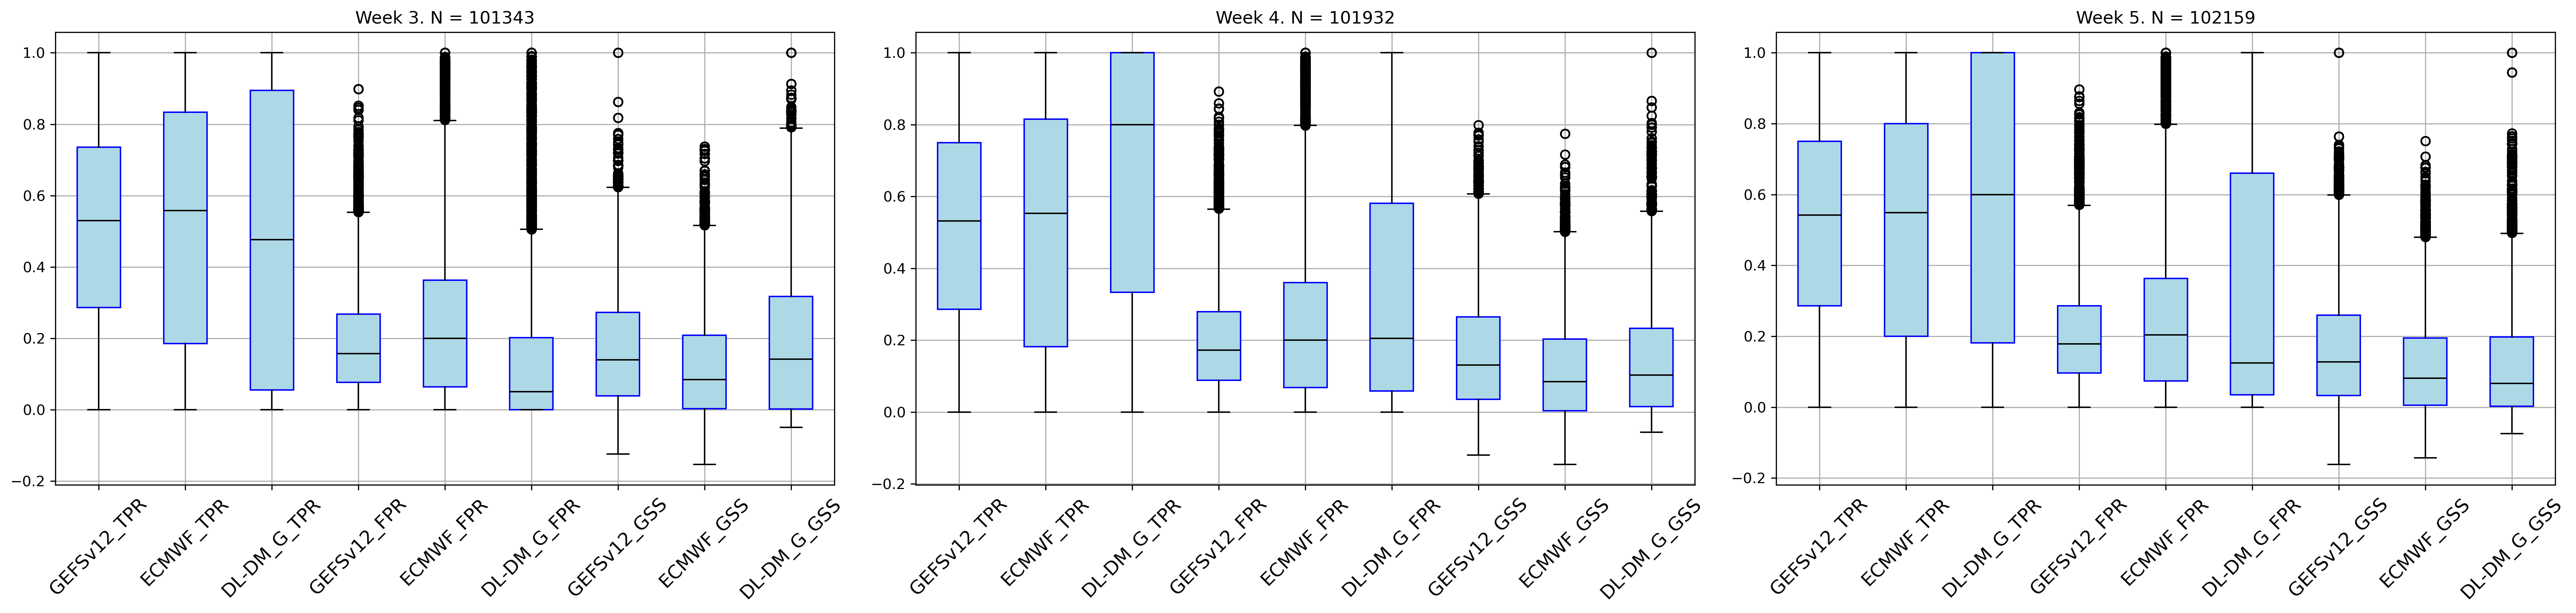

In [16]:

def compute_mean_and_confidence_interval_histogram_distribution(data_dict):
    all_data = {}
    for week_lead in ['3','4','5']:
        out_df = pd.DataFrame(columns = data_dict[week_lead].columns)
        
        subset = data_dict[week_lead]
        #First remove np.nan values
        data = subset.dropna(axis=0)
        all_data[week_lead] = data

    plot_dict = {}
    for week_lead in ['3','4','5']:
        out_df = pd.DataFrame(columns = data_dict[week_lead].columns)
        
        subset = data_dict[week_lead]
        #First remove np.nan values
        data = subset.dropna(axis=0)
    
        # Calculate mean and standard deviation
        mean = np.mean(data,axis=0)
        std_dev = np.std(data,axis=0)
        
        # Number of samples
        n = len(data)
        
        # Define confidence level (e.g., 95%)
        confidence_level = 0.95
        
        # Calculate the standard error of the mean
        standard_error = std_dev / np.sqrt(n)
        
        # Calculate the margin of error
        margin_of_error = stats.t.ppf((1 + confidence_level) / 2, n - 1) * standard_error
        
        # Calculate the confidence interval
        lower_bound = mean - margin_of_error
        upper_bound = mean + margin_of_error
    
        result = pd.concat([lower_bound, mean, upper_bound],axis=1)
        result.columns = ['Lower Bound', 'Mean', 'Upper Bound']
        result['n_samples'] = n

        plot_dict[week_lead] = result

    
    return(all_data, plot_dict)

all_data, plot_dict = compute_mean_and_confidence_interval_histogram_distribution(data_dict)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6),dpi=300)
axes = axes.flatten()

axes_start = 0
for week_lead in ['3','4','5']:
    bounds = plot_dict[week_lead]
    new_order = ['GEFSv12_TPR','ECMWF_TPR','UNET_TPR','GEFSv12_FPR','ECMWF_FPR','UNET_FPR','GEFSv12_GSS','ECMWF_GSS','UNET_GSS']
    bounds = bounds.reindex(new_order)
    bounds.rename(index={'GEFSv12_TPR': 'GEFSv12_TPR', 'ECMWF_TPR': 'ECMWF_TPR', 
                 'UNET_TPR': 'DL-DM_G_TPR', 'GEFSv12_FPR': 'GEFSv12_FPR',
                'ECMWF_FPR':'ECMWF_FPR','UNET_FPR':'DL-DM_G_FPR',
                'GEFSv12_GSS':'GEFSv12_GSS', 'ECMWF_GSS':'ECMWF_GSS',
                'UNET_GSS':'DL-DM_G_GSS'}, inplace=True)

    
    lower_bound = bounds['Lower Bound'].T
    upper_bound = bounds['Upper Bound'].T
    means = bounds['Mean'].T
    
    all = all_data[week_lead]
    all = all[['GEFSv12_TPR','ECMWF_TPR','UNET_TPR','GEFSv12_FPR','ECMWF_FPR','UNET_FPR','GEFSv12_GSS','ECMWF_GSS','UNET_GSS']]

    # Define color dictionary
    color_dict = {
        'TPR': 'skyblue',
        'FPR': 'lightgreen',
        'GSS': 'salmon'
    }
    # plt.boxplot(all, labels=all.columns, showmeans=False)
    axes[axes_start].boxplot(all, labels=all.columns, showmeans=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='black'))
    
    # # Plotting confidence intervals
    # plt.errorbar(x=np.arange(1, 10), y=means, yerr=[means - lower_bound, upper_bound - means],
    #              fmt='o', color='red', label='Confidence Intervals', capsize=15)
    
    axes[axes_start].set_title(f'Week {week_lead}. N = {len(all)}')
    axes[axes_start].set_xticklabels(labels = ['GEFSv12_TPR','ECMWF_TPR','DL-DM_G_TPR','GEFSv12_FPR','ECMWF_FPR','DL-DM_G_FPR','GEFSv12_GSS','ECMWF_GSS','DL-DM_G_GSS'],
                                     rotation=45,fontsize=13)
    axes[axes_start].grid(True)
    # plt.xlabel('Groups')
    # plt.ylabel('Values')
    axes_start+=1

# plt.legend()
plt.tight_layout()
plt.savefig(f'Outputs/TPR_FPR_GSS/sampling_distribution.png')
plt.show()

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot each variable separately
for i, (index, row) in enumerate(df.iterrows()):
    plt.errorbar(x=i, y=row['Mean'], yerr=[[row['Mean'] - row['Lower Bound']], [row['Upper Bound'] - row['Mean']]], fmt='o', label=index)

plt.xticks(range(len(df.index)), df.index)
plt.xlabel('Variables')
plt.ylabel('Values')
plt.title('Mean Values with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()